# 00_dataset_intro.ipynb

Here, we inspect the different datasets that we will be using in this project:

* USGS 3DEP Aerial LiDAR (CO_WestCentral_2019) DSM
    * "Ground truth" data to serve as a reference for the ICESat-2 ATL06 measurements
    * Processed with a custom PDAL pipeline
* ICESat-2 ATL06 elevation points
    * Processed with [SlideRule](https://slideruleearth.io/)

In [52]:
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import coincident
import xdem
import numpy as np
import sliderule
from sliderule import icesat2, earthdata
import contextily as ctx
%matplotlib inline

### Aerial LiDAR

The USGS 3DEP LiDAR project [CO_WestCentral_2019](https://portal.opentopography.org/usgsDataset?dsid=CO_WestCentral_2019) was flown over western Colorado's Gunnison National Forest in August and September of 2019. This mission is part of USGS's efforts to create a national baseline of consistent high-resolution elevation data and spans 11,388 km2 with 100,975,650,743 total points (8.87 pts/m2 point density).

This data was processed using a customized [PDAL](https://pdal.io/en/2.8.4/) pipeline adapted from the repository: https://github.com/uw-cryo/lidar_tools . The specific processing parameters are uknown (for now)... Additionally, we only use a small subset of the resulting DSM as this elevation model was processed as part of NASA's Surface Terrain and Vegetation Incubation Program's [Precursor Coincident Dataset](https://science.nasa.gov/earth-science/decadal-surveys/decadal-stv/coincident-datasets/) efforts. So, this subset was chosen because the area has near-contemporaneous, coincident overlaps with other elevation datasets of interest, but for the sake of this project, we will only be looking at coincident ICESat-2 observations. Additionally, this subset is resampled from 1m spatial resolution to 8m for computational efficiency purposes. This was achieved with the below [GDAL](https://gdal.org/) code

```{note}
gdaladdo -q -ro -r gauss --config COMPRESS_OVERVIEW LZW --config BIGTIFF_OVERVIEW YES dem_1m.tif 2 4 8 16

gdal_translate -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -outsize 12.5% 12.5% dem_1m.tif dem_8m.tif
```

In [31]:
# read in the 3dep data with rioxarray mask=True
da_3dep = rxr.open_rasterio("/mnt/c/Users/JackE/uw/STV/agu_24/data/CO_WestCentral_2019/3dep_8m/merged_dsm_reprojected_8m.tif",
                              masked=True)

In [32]:
# now project to the corresponding UTM CRS and transform into an Xarray dataset
crs_utm = "EPSG:32613"
da_3dep.rio.write_crs(crs_utm, inplace=True)
ds_3dep = da_3dep.to_dataset(name="elevation")

In [33]:
print(f"ds_3dep shape: {ds_3dep.rio.shape}")
print(f"ds_3dep resolution (m): {ds_3dep.rio.resolution()}")
print(f"ds_3dep crs: {ds_3dep.rio.crs}")
pixel_count = ds_3dep.rio.shape[0] * ds_3dep.rio.shape[1]
pixel_area = abs(ds_3dep.rio.resolution()[0] * ds_3dep.rio.resolution()[1])
area_km2 = (pixel_count * pixel_area) / 1e6
print(f"ds_3dep area: {area_km2:.2f} km²")

ds_3dep shape: (5664, 3900)
ds_3dep resolution (m): (8.001282051282052, -8.000176553672317)
ds_3dep crs: EPSG:32613
ds_3dep area: 1413.99 km²


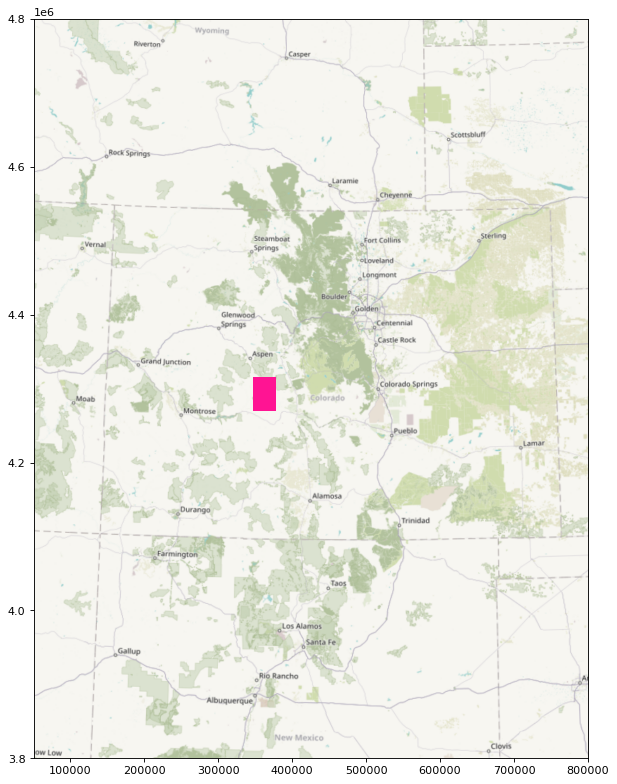

In [83]:
bounds_3dep = ds_3dep.rio.bounds()
gf_3dep_bounds = gpd.GeoDataFrame(
    geometry=[box(*bounds_3dep)], 
    crs=ds_3dep.rio.crs
)
#gf_3dep_bounds.explore(
#    style_kwds={'fillOpacity': 0.1, 'color': 'deeppink'}
#)
# for github display purposes because i don't want to use nbviewer
f, ax = plt.subplots(figsize=(10,12),dpi=80)
gf_3dep_bounds.plot(ax=ax, color='deeppink', alpha=1)
ax.set_xlim([50000,800000])
ax.set_ylim([3.8e6,4.8e6])
ctx.add_basemap(ax, crs=ds_3dep.rio.crs, attribution=False)

#### terrain variables

In [35]:
# use xdem to derive hillshade, slope, and aspect values
# there's probably a better way to do this, but this works for now...

# need to use exactly 8m resolution first since xdem terrain attributes requires equal resolution
slope = xdem.terrain.slope(ds_3dep.elevation.values, resolution=8.0)
aspect = xdem.terrain.aspect(ds_3dep.elevation.values)
hillshade = xdem.terrain.hillshade(ds_3dep.elevation.values, resolution=8.0, azimuth=315, altitude=45)

ds_3dep['slope'] = (('y', 'x'), np.squeeze(slope))
ds_3dep['aspect'] = (('y', 'x'), np.squeeze(aspect))
ds_3dep['hillshade'] = (('y', 'x'), np.squeeze(hillshade))

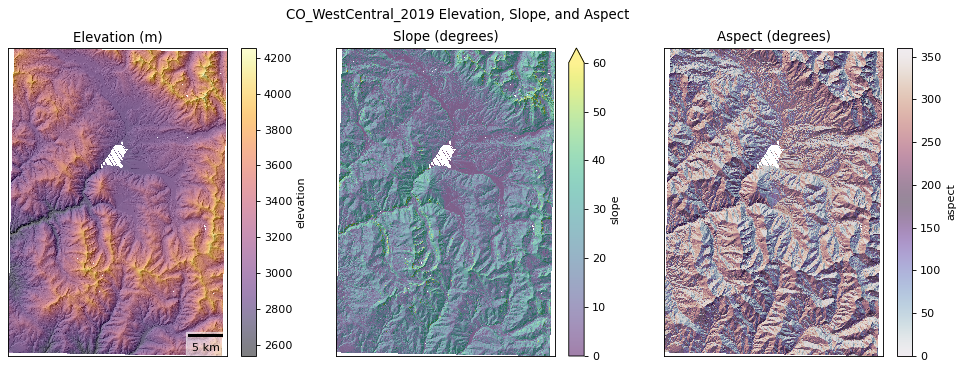

In [51]:
# lower dpi for display purposes
f, axs = plt.subplots(1,3, figsize=(15,5), 
                      sharex=True, sharey=True, dpi=80)

# elevation
# ---------------
ax=axs[0]
ds_3dep.hillshade.plot.imshow(cmap='gray', alpha=1, ax=ax, add_colorbar=False)
ds_3dep.elevation.squeeze().plot.imshow(cmap='inferno', alpha=0.5, ax=ax)
ax.set_title("Elevation (m)")
scalebar = ScaleBar(dx=1.0, units='m', location='lower right',
                    box_alpha=0.5, box_color='white')
ax.add_artist(scalebar)

# slope
# ---------------
ax=axs[1]
ds_3dep.hillshade.plot.imshow(cmap='gray', alpha=1, ax=ax, add_colorbar=False)
ds_3dep.slope.plot.imshow(cmap='viridis', alpha=0.5, ax=ax, vmax=60)
ax.set_title("Slope (degrees)")

# aspect
# ---------------
ax=axs[2]
ds_3dep.hillshade.plot.imshow(cmap='gray', alpha=1, ax=ax, add_colorbar=False)
ds_3dep.aspect.plot.imshow(cmap='twilight', alpha=0.5, ax=ax)
ax.set_title("Aspect (degrees)")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("CO_WestCentral_2019 Elevation, Slope, and Aspect");

#### land cover

Here, we use the newest hottest sexiest humblest library [coincident](https://coincident.readthedocs.io/en/latest/) to grab ESA worldcover data

> [!WARNING]  
> This will be replaced with more-accurate "ecozone" and LULC data

In [37]:
# now, let's bring in ESA Worldcover data to see some broad land cover classifications
# Load Worldcover for this bounding box
gf_wc = coincident.search.search(
    dataset="worldcover",
    intersects=gf_3dep_bounds.to_crs(4326), # 4326 for search
)
ds_wc = coincident.io.xarray.to_dataset(
    gf_wc,
    bands=["map"],
    like=ds_3dep, # Match grid
).rename(map="landcover")

In [38]:
ds_wc = ds_wc.compute()

In [39]:
# well that's awkward, the below isn't working as expected but we'll fix that soon
#ax = coincident.plot.plot_esa_worldcover(ds_wc)
#ax.set_title("CO_WestCentral_2019: ESA WorldCover");

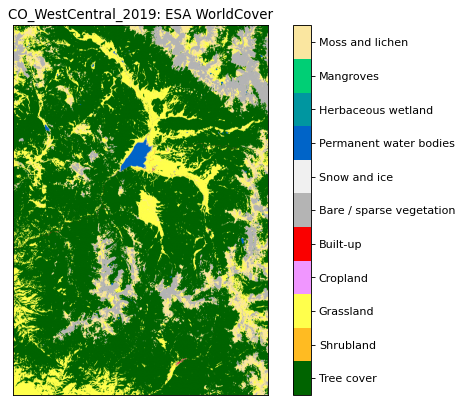

In [40]:
# let's just pull out the source code and manually change it
from coincident.datasets.planetary_computer import WorldCover
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# WorldCover colormap and normalization
classmap = WorldCover().classmap
colors = ["#000000" for r in range(256)]
for key, value in classmap.items():
    colors[int(key)] = value["hex"]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

# Plot the data - selecting the 2021 as opposed to 2020
im = ax.imshow(ds_wc.landcover.sel(time="2021-01-01").squeeze(), cmap=cmap, norm=norm)

# colorbar
values = list(classmap)
boundaries = [(values[i + 1] + values[i]) / 2 for i in range(len(values) - 1)]
boundaries = [0, *boundaries, 255]
ticks = [(boundaries[i + 1] + boundaries[i]) / 2 for i in range(len(boundaries) - 1)]
tick_labels = [value["description"] for value in classmap.values()]

colorbar = fig.colorbar(im, boundaries=boundaries, values=values)
colorbar.set_ticks(ticks, labels=tick_labels)

ax.set_title("CO_WestCentral_2019: ESA WorldCover")
ax.set_xticks([])
ax.set_yticks([]);

### ICESat-2

For a deeper explanation on ICESat-2, see the README.md file. Here, we use [SlideRule](https://slideruleearth.io/) to look at the standard processing mode for [ATL06](https://slideruleearth.io/web/rtd/api_reference/icesat2.html#atl06s) land ice elevation products. The goal of this project is to compare this standard processing algorithm with [custom ATL06 processing algorithms](https://slideruleearth.io/web/rtd/api_reference/icesat2.html#atl06p) where we tweak the various [processing parameters](https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html#parameters).

In [41]:
# TODO: add more detail to specific processing parameters in MD above
sliderule.init("slideruleearth.io", verbose=True)
earthdata.set_max_resources(max_resources=1000)

Setting URL to slideruleearth.io


In [42]:
gf_3dep_bounds_4326 = gf_3dep_bounds.to_crs(4326) # search area in 4326
start = "2019-08-21T00:00:00Z" # 3dep survey start date
end = "2019-09-19T00:00:00Z" # 3dep survey end date

In [43]:
parms = {
    "poly": sliderule.toregion(gf_3dep_bounds_4326)['poly'],
    "t0": start,
    "t1": end,
}

In [44]:
# TODO: add commentary on what processing ATL03 granules means
atl06 = icesat2.atl06p(parms, keep_id=True)

request <AppServer.11870> retrieved 2 resources from CMR
Starting proxy for atl06 to process 2 resource(s) with 2 thread(s)
request <AppServer.11681> processing initialized on ATL03_20190905065620_10570402_006_02.h5 ...
request <AppServer.11871> processing initialized on ATL03_20190903191210_10340406_006_02.h5 ...
request <AppServer.11681> processing of ATL03_20190905065620_10570402_006_02.h5 complete (463311/4313/0)
request <AppServer.11681> processing complete (1500/1/1500/0)
Successfully completed processing resource [2 out of 2]: ATL03_20190905065620_10570402_006_02.h5
request <AppServer.11871> processing of ATL03_20190903191210_10340406_006_02.h5 complete (398773/8191/0)
request <AppServer.11871> processing complete (5137/1/5137/0)
Successfully completed processing resource [1 out of 2]: ATL03_20190903191210_10340406_006_02.h5


In [45]:
print(atl06.shape)
atl06.head(2)

(6637, 17)


,n_fit_photons,pflags,y_atc,x_atc,rgt,gt,rms_misfit,region,h_sigma,segment_id,extent_id,dh_fit_dx,h_mean,spot,w_surface_window_final,cycle,geometry
time,,,,,,,,,,,,,,,,,
2019-09-03 19:17:32.482213376,65,0,-7920.236816,15734789.0,1034,10,0.551222,6,0.068512,785594,4656722316422545410,-0.044009,3403.864567,1,3.965971,4,POINT (-106.61453 38.97879)
2019-09-03 19:17:32.485044736,99,0,-7920.046387,15734809.0,1034,10,3.269042,6,0.330702,785595,4656722316422545414,0.112393,3405.805182,1,23.443512,4,POINT (-106.61455 38.97861)


In [46]:
atl06.describe()

,n_fit_photons,pflags,y_atc,x_atc,rgt,gt,rms_misfit,region,h_sigma,segment_id,extent_id,dh_fit_dx,h_mean,spot,w_surface_window_final,cycle
count,6637.000000,6637.000000,6637.000000,6637.0,6637.000000,6637.000000,6637.000000,6637.000000,6637.000000,6637.000000,6.637000e+03,6637.000000,6637.000000,6637.000000,6637.000000,6637.0
mean,54.625584,0.178997,-6180.046387,13181714.0,1039.198132,33.891819,2.479790,5.095977,0.419269,658064.508061,4.680133e+18,-0.044061,3175.497404,3.389182,14.074590,4.0
std,38.099475,0.800218,10188.336914,4781774.5,9.620312,16.684925,2.653698,1.673098,0.452402,238852.388355,4.332603e+16,0.372365,277.023105,1.668493,12.074426,0.0
min,10.000000,0.000000,-14542.427734,4294208.0,1034.000000,10.000000,0.000000,2.000000,0.000000,214131.000000,4.656722e+18,-14.877963,2447.264848,1.000000,3.000000,4.0
25%,26.000000,0.000000,-14383.694336,15736994.0,1034.000000,20.000000,0.795980,6.000000,0.117323,785704.000000,4.656722e+18,-0.185378,2939.368247,2.000000,5.204600,4.0
50%,46.000000,0.000000,-11164.119141,15760005.0,1034.000000,30.000000,1.561389,6.000000,0.242476,786852.000000,4.656722e+18,-0.045508,3155.442229,3.000000,9.880314,4.0
75%,78.000000,0.000000,-7944.181641,15774477.0,1034.000000,50.000000,3.713424,6.000000,0.585223,787574.000000,4.656722e+18,0.096160,3379.459641,5.000000,23.538170,4.0
max,988.000000,4.000000,14526.539062,15781072.0,1057.000000,60.000000,97.425850,6.000000,7.824130,787903.000000,4.760305e+18,8.048935,4006.003335,6.000000,379.388550,4.0


In [47]:
atl06_p = atl06.to_crs(ds_3dep.rio.crs)

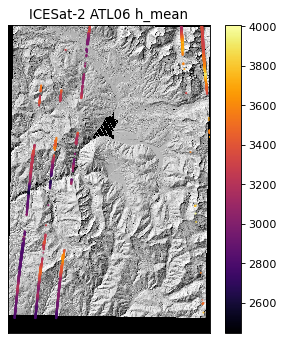

In [48]:
# lower dpi for display purposes
f, ax = plt.subplots(figsize=(5,5), dpi=80)

ds_3dep.hillshade.plot.imshow(cmap='gray', alpha=1, ax=ax, add_colorbar=False)
atl06_p.plot(column="h_mean", cmap='inferno', alpha=0.5, s=0.5, ax=ax, legend=True)
ax.set_title("ICESat-2 ATL06 h_mean")

ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel("")
ax.set_xlabel("");

In [49]:
# as you can see, the points are quite sparse in terms of spatial distribution.... more on that later